In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from maelstrom.maelstrom import Maelstrom

/Users/sjm/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
kicid = 6862920

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

In [4]:
model = Maelstrom(times, dmmags, nu_arr)
model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

In [5]:
model.get_session().run(model.chi2)

388931.49899253412

In [6]:
model.optimize([model.period])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 388926.133892
  Number of iterations: 4
  Number of functions evaluations: 6


In [7]:
model.optimize([model.period, model.lighttime])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 388069.632257
  Number of iterations: 22
  Number of functions evaluations: 28


In [8]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 387882.441996
  Number of iterations: 17
  Number of functions evaluations: 26


In [9]:
model.nu_data - model.get_session().run(model.nu)

array([ -1.52384713e-07,   1.65150283e-07,  -6.87391459e-08,
         9.59177586e-08,   7.47823602e-07,   1.40951036e-07,
         3.49691717e-07,   3.48999100e-07,  -2.25961054e-08,
         3.96408058e-04])

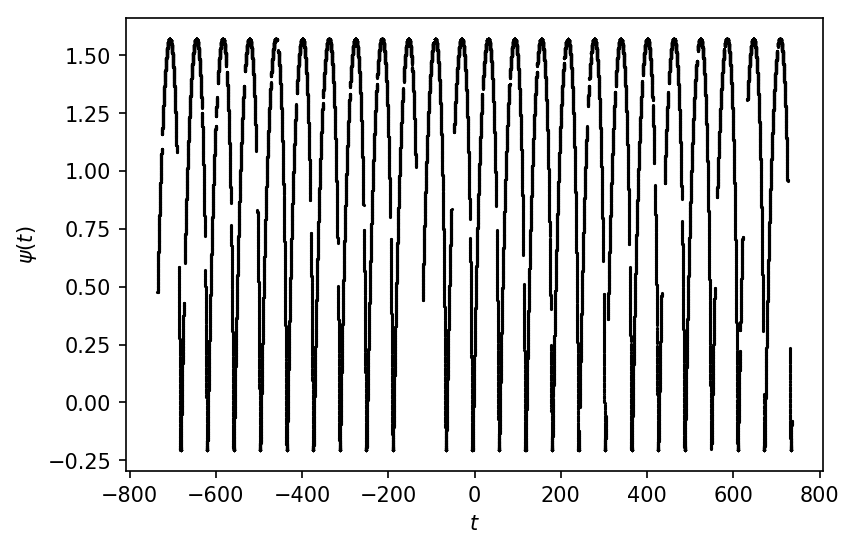

In [10]:
plt.plot(times, model.run(model.psi), ".k", ms=1)
plt.ylabel("$\psi(t)$")
plt.xlabel("$t$");

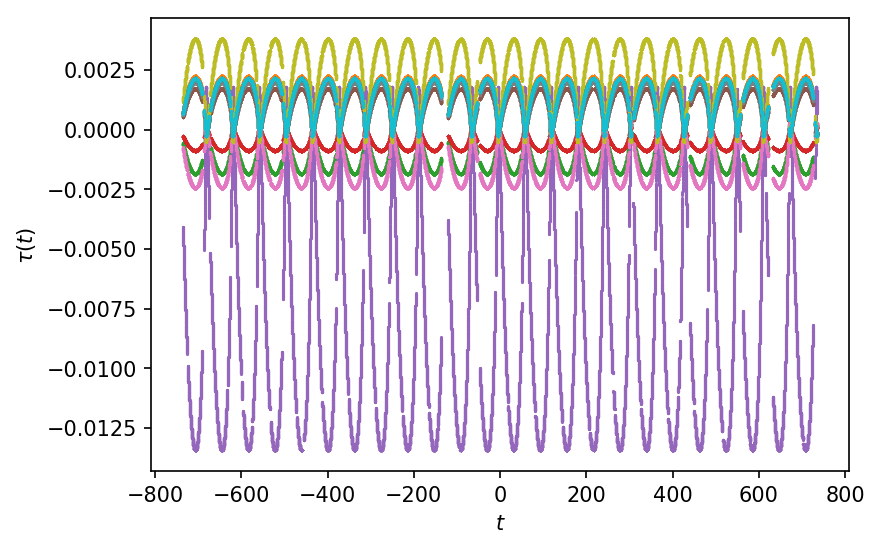

In [11]:
plt.plot(times, model.run(model.tau), ".", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

In [12]:
lt, lt_err = model.get_lighttime_estimates()
nu = model.run(model.nu)
plt.errorbar(nu, lt, yerr=lt_err, fmt="k.")
plt.ylim(-0.01, 0.01)
plt.xlabel(r"$\nu$")

TypeError: 'IndexedSlices' object is not subscriptable